In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from tsfresh.feature_extraction import MinimalFCParameters

from drift_ml.datasets.bosch_cnc_machining.models.nnclassifier import NNClassifier, NNEnsembleClassifier
from drift_ml.datasets.bosch_cnc_machining.utils.experiment import DriftExperiment
from drift_ml.datasets.bosch_cnc_machining.utils.utils import augment_xyz_samples
from drift_ml.datasets.bosch_cnc_machining.utils.dataloader import DriftDataLoader, NPYBoschCNCDataLoader, Standardizer


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from driftdec.utils.detectors import (
    BlindDetector,
    ErrorRateBasedRiverDetector,
    UncertaintyBasedRiverDetector,
    ErrorBasedNannyMLDetector,
    UncertaintyBasedNannyMLDetector,
    PCAReconstructionErrorBasedNannyMLDetector,
)
from driftdec.utils.classifier import HyperparameterTunedClassifer


from river.drift import ADWIN, DDM
from nannyml.drift.univariate.methods import (
    JensenShannonDistance,
    KolmogorovSmirnovStatistic,
    Chi2Statistic,
    LInfinityDistance,
    WassersteinDistance,
    HellingerDistance,
)

/home/tbiegel/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
base_loader = NPYBoschCNCDataLoader(metadata_path="/home/tbiegel/nico_files/cms_2023_code/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/metadata_ws4096.pkl")
base_loader.load_data(
    sample_data_x_path="/home/tbiegel/nico_files/cms_2023_code/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/npy/sample_data_x_raw_ws4096.npy",
    sample_data_y_path="/home/tbiegel/nico_files/cms_2023_code/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/npy/sample_data_y_raw_ws4096.npy"
    )

In [6]:
sudden_config = {
    "mode": {
        "features": "stft",
        "featureset": None,#MinimalFCParameters()
    },
    "base_config": {
        "train_size": 0.4,
        "val_size": 0.1, 
        "test_size": 0.5,
        "machines": None,
        "processes": None,
        "periods": ["Feb_2019","Aug_2019","Feb_2020"],
    },
    "drift_config": [
        {
            "length": None,#10000,
            "type": "constant",
            "only_test": True,  # todo: False,
            "machines": None,
            "processes": None,
            "periods":  ["Feb_2019","Aug_2019","Feb_2020"],
            "transform_fn": None,
        },
        {
            "length": None,#10000,
            "type": "constant",
            "only_test": True,  # todo: False,
            "machines": None,
            "processes": None,
            "periods":  ["Aug_2020","Feb_2021","Aug_2021"],
            "transform_fn": None,# lambda x: augment_xyz_samples(x, pitch_deg=30),
        }
    ],
}

In [14]:
# detector = UncertaintyBasedNannyMLDetector(
#     detector_class=KolmogorovSmirnovStatistic, max_window_len=1000, step=1, detector_params={},
# )

random_seed = 42

drift_dataloader = DriftDataLoader(baseloader=base_loader, config=sudden_config, random_seed=random_seed)

In [15]:
print(drift_dataloader.max_drift_data_length, drift_dataloader.config_change_points)

21722 [14851, 21722]


In [16]:
detector = UncertaintyBasedRiverDetector(
    detector_class=ADWIN, detector_params={}
)

model = Pipeline([('standardizer', Standardizer()), ('cnn', NNClassifier(
    temperature=1.0, random_seed=random_seed, epochs=80
))])

experiment = DriftExperiment(
    model,
    drift_dataloader,
    drift_detector=detector,
    chunksize=5000,
    window_size=500,
    name="test_run",
    result_dir="/home/tbiegel/nico_files/cms_2023_code/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/experiment_results",
    length=21500,
    retrain_at_drift=True,
    retrain_with_train_set=True,
    retrain_new_parts=100,
    fit_model=True,
    val_model=True
)
experiment.run()

Doing the initial training of the model.


Training NN:   0%|          | 0/80 [00:00<?, ?it/s]

Val results:
Starting experiment queue...


accuracy: 1.00
mcc: 0.94
f1: 0.94
precision: 0.92
recall: 0.96


  0%|          | 0/21500 [00:00<?, ?it/s]

Drift detected at 15711
Retraining at index 15711


Config 1 length is 6871
Taking 100 parts with 2643 samples
Remaining length is 3368
(13786, 3, 129, 33)
(13786,)
385.0


Training NN:   0%|          | 0/80 [00:00<?, ?it/s]

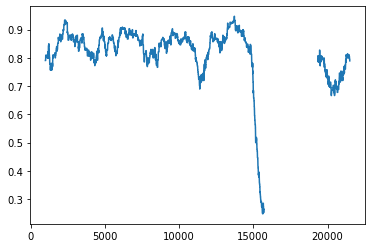

In [17]:
plt.plot(experiment.metric_results_pred["f1"])
plt.show()

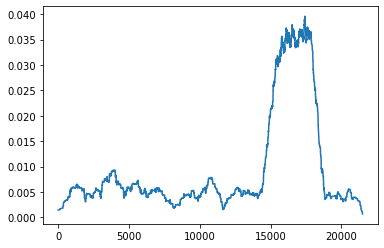

In [18]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

plt.plot(movingaverage(experiment.y_pred_entr, 1000))
plt.show()